## Import Modules and define all necessary functions 

In [1]:
import pandas as pd
import numpy as np
import re
import random
import math 
from bs4 import BeautifulSoup 
import nltk
from nltk.corpus import stopwords
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.spatial import distance
from sklearn.metrics.pairwise import *
import time
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    
    # Remove HTML
    review_text = BeautifulSoup(raw_review).get_text()

    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()

    # Convert the stop words to a set
    stops = set(stopwords.words("english"))

    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]

    # Join the words back into one string and return the result.
    return (" ".join(meaningful_words))

def count_words(cleaned_reviews):

    # Bag of words tool
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 5000)

    cleaned_features = vectorizer.fit_transform(cleaned_reviews)
    cleaned_features = cleaned_features.toarray()

    return cleaned_features

def get_binary(X_counts):

    X_counts[X_counts>0] = 1

    return X_counts

def get_tfidf(X_counts):

    # tfidf transformer
    transformer = TfidfTransformer(smooth_idf=False)

    X_tfidf = transformer.fit_transform(X_counts)
    X_tfidf = X_tfidf.toarray()

    return X_tfidf

def get_binary_imbalance(train):

    # get positive train data
    train_pos = train[train["sentiment"] == 1]
    index_pos = train_pos.index

    # set random index to delete
    random.seed(0)
    random_index = random.sample(range(index_pos.size),int(index_pos.size * 0.75))

    # delete chosen random index data
    for num in random_index:
        random_index = index_pos[num]
        train = train.drop(random_index)

    # from new train data get binary counts table
    total_reviews = train["review"].index
    cleaned_reviews = []

    for i in total_reviews:
        cleaned_reviews.append(review_to_words(train["review"][i]))

    X_counts = count_words(cleaned_reviews)
    X_binary_imbalance = get_binary(X_counts)

    return X_binary_imbalance,total_reviews

def dist(X,i,j):

    # get euclidean distance
    dist = distance.euclidean(X[i],X[j])

    return dist

def topk(X,k):
    # Fint top k closest pair of matrix X

    # initialize distance list and record dictionary
    distance_list = []
    record_dict = {}

    X_sparse = sparse.csr_matrix(X)
    dis_sparse = pairwise_distances(X_sparse)

    for i in range(0,X.shape[0]):

        for j in range(i+1,X.shape[0]):
            dist_temp = dis_sparse[i,j]
                
            # add record to dist
            record_dict[dist_temp] = (i,j,dist_temp)

            # get top k closest pairs
            if len(distance_list) < k:
                distance_list.append(dist_temp)
            else:
                distance_list.sort()
                if dist_temp <= distance_list[-1]:
                    distance_list[-1] = dist_temp

    distance_list.sort()
    closest_pair = []

    # get closest pair
    for i in distance_list:
        closest_pair.append(record_dict[i])

    return closest_pair

def print_closest(matrix_name,pair,train):

    # print the faature space similarity experiment
    print("Feature space similarity experiment for " + matrix_name)

    print("The indices of the reviews are: " + str(pair[0][0]) + " and " + str(pair[0][1]))

    print("The distance is: " + str(pair[0][2]))

    raw_review = train["review"][pair[0][0]]
    review = review_to_words(raw_review)
    print("The review of " + str(pair[0][0]) + " is: " + review[:20])

    raw_review = train["review"][pair[0][1]]
    review = review_to_words(raw_review)
    print("The review of " + str(pair[0][1]) + " is: " + review[:20])

    print("The label of " + str(pair[0][0]) + " is: " + str(train["sentiment"][pair[0][0]]))

    print("The label of " + str(pair[0][1]) + " is: " + str(train["sentiment"][pair[0][1]]) + "\n")

def print_closest_imbalance(pair,train,index):

    # print the faature space similarity experiment
    print("Feature space similarity experiment for X_binary_imbalance")

    print("The indices of the reviews are: " + str(index[pair[0][0]]) + " and " + str(index[pair[0][1]]))

    print("The distance is: " + str(pair[0][2]))

    raw_review = train["review"][index[pair[0][0]]]
    review = review_to_words(raw_review)
    print("The review of " + str(index[pair[0][0]]) + " is: " + review[:20])

    raw_review = train["review"][index[pair[0][1]]]
    review = review_to_words(raw_review)
    print("The review of " + str(index[pair[0][1]]) + " is: " + review[:20])

    print("The label of " + str(index[pair[0][0]]) + " is: " + str(train["sentiment"][index[pair[0][0]]]))

    print("The label of " + str(index[pair[0][1]]) + " is: " + str(train["sentiment"][index[pair[0][1]]]) + "\n")

def get_kfold_acc(X,Y,c):

    # kfold split validation
    kf = KFold(Y.size,n_folds = 5, random_state = 0)
    svm = LinearSVC(C = c)
    #svm = SVC(kernel='linear', C=c)
    auc = []

    # get kfold auc value
    for train_indice,test_indice in kf:
        X_train,X_test = X[train_indice],X[test_indice]
        Y_train,Y_test = Y[train_indice],Y[test_indice]
        X_train_sparse = sparse.csr_matrix(X_train)
        svm.fit(X_train_sparse, Y_train)
        X_test_sparse = sparse.csr_matrix(X_test)
        prediction = svm.predict(X_test_sparse)
        Y_pred = np.array(prediction)
        auc_temp = roc_auc_score(Y_test, Y_pred)
        auc.append(auc_temp)

    auc_avg = float(sum(auc))/len(auc)
    return auc_avg

def get_best_c(X,Y):

    # set uniformal distributed coefficients
    coef = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    c_value = []
    for i in range(30):
        temp_mul = random.sample(range(0,9),1)
        c_value.append(coef[temp_mul[0]]*(random.random()))

    auc = []

    # calculate k fold auc value
    for c in c_value:
        auc_temp = get_kfold_acc(X,Y,c)
        auc.append(auc_temp)

    auc_max = max(auc)
    c_best = c_value[auc.index(auc_max)]

    return c_best,auc_max

def split_data(X,train):

    num = X.shape[0]
    split_num = int(num * 0.8)

    random.seed(0)
    train_index = random.sample(range(num),split_num)

    test_index = []
    for i in range(num):
        if i not in train_index:
            test_index.append(i)

    train_data = []
    for i in train_index:
        train_data.append(X[i])
    train_data = np.array(train_data)

    train_label = []
    for i in train_index:
        train_label.append(train["sentiment"][i])
    train_label = np.array(train_label)

    test_data = []
    for i in test_index:
        test_data.append(X[i])
    test_data = np.array(test_data)

    test_label = []
    for i in test_index:
        test_label.append(train["sentiment"][i])
    test_label = np.array(test_label)

    return train_data,train_label,test_data,test_label

def split_data_imbalance(X,train,index):

    num = X.shape[0]
    split_num = int(num * 0.8)

    random.seed(0)
    train_index_temp = random.sample(range(num),split_num)

    test_index_temp = []
    for i in range(num):
        if i not in train_index_temp:
            test_index_temp.append(i)

    train_index = []
    for i in train_index_temp:
        train_index.append(index[i])

    test_index = []
    for i in test_index_temp:
        test_index.append(index[i])

    train_data = []
    for i in train_index_temp:
        train_data.append(X[i])
    train_data = np.array(train_data)

    train_label = []
    for i in train_index:
        train_label.append(train["sentiment"][i])
    train_label = np.array(train_label)

    test_data = []
    for i in test_index_temp:
        test_data.append(X[i])
    test_data = np.array(test_data)

    test_label = []
    for i in test_index:
        test_label.append(train["sentiment"][i])
    test_label = np.array(test_label)

    return train_data,train_label,test_data,test_label

def get_retrained_score(X_train, Y_train, X_test, c):

    # initial svm and kfold
    svm = LinearSVC(C = c)
    #svm = SVC(kernel='linear', C=c, probability=True)

    X_train_sparse = sparse.csr_matrix(X_train)
    X_test_sparse = sparse.csr_matrix(X_test)

    svm.fit(X_train_sparse, Y_train)

    score = svm.decision_function(X_test_sparse)

    #pos_score = score[:,1]
    
    return score

def plot(y_test,y_score,kaggle_score):
    fpr = []
    tpr = []
    roc_auc = []

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    show_kaggle = "Kaggle Score: " + str(kaggle_score)

    # plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='limegreen',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.03])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.text(0.55,0.12,show_kaggle)
    plt.show()
    
def plot_learning_curve(estimator, title, X, y):
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=[100,500,1000,2000,3000,4000,5000,7500,15000,20000], cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()



/root/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Main Funtion - Preprocess the features and get four feature matrixs

In [2]:
    train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

    num_reviews = train["review"].index

    clean_train_reviews = []

    for i in num_reviews:
        if (i+1)%1000 == 0 : 
            print ("Review %d of %d\n" %(i+1,len(num_reviews)))
        clean_train_reviews.append(review_to_words(train["review"][i]))

    X_counts = count_words(clean_train_reviews)

    X_binary = get_binary(X_counts)

    X_tfidf = get_tfidf(X_counts)

    X_binary_imbalance, train_index = get_binary_imbalance(train)

/root/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /root/miniconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



## Question 1:  Feature Space Similarity Experiment

#Step 1: The closest pair for X_count matrix

In [ ]:
    pair = topk(X_counts,1)
    print_closest("X_counts",pair,train)

#Step 2: The closest pair for X_binary matrix

In [ ]:
    pair = topk(X_binary,1)
    print_closest("X_binary",pair,train)

#Step 3: The closest pair for X_tfidf

In [ ]:
    pair = topk(X_tfidf,1)
    print_closest("X_tfidf",pair,train)

#Step 4: The closest pair for X_imbalance_binary

In [ ]:
    pair = topk(X_binary_imbalance,1)
    print_closest_imbalance(pair,train,train_index)

## Question 2: Estimate and pick the best C value for 4 design matrix 

#Step 1: Pick the best C value for X_counts

In [ ]:
    X_train,Y_train,X_test,Y_test = split_data(X_counts,train)
    c_best,auc_max = get_best_c(X_train,Y_train)
    print("Best c value and its auc score for X_counts")
    print(c_best)
    print(auc_max)

#Step 2: Pick the best C value for X_binary

In [ ]:
    X_train,Y_train,X_test,Y_test = split_data(X_binary,train)
    c_best,auc_max = get_best_c(X_train,Y_train)
    print("Best c value and its auc score for X_binary")
    print(c_best)
    print(auc_max)

#Step 3: Pick the best C value for X_tfidf

In [ ]:
    X_train,Y_train,X_test,Y_test = split_data(X_tfidf,train)
    c_best,auc_max = get_best_c(X_train,Y_train)
    print("Best c value and its auc score for X_tfidf")
    print(c_best)
    print(auc_max)

#Step 4: Pick the best C value for X_binary_imbalance

In [ ]:
    X_train,Y_train,X_test,Y_test = split_data_imbalance(X_binary_imbalance,train,train_index)
    c_best,auc_max = get_best_c(X_train,Y_train)
    print("Best c value and its auc score for X_binary_imbalance")
    print(c_best)
    print(auc_max)

## Question 3: Retrain classifier and get AUC-ROC plot for 4 design matrix

#Step 1: Get AUC-ROC plot for X_counts

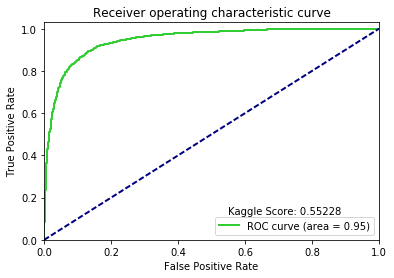

In [7]:
    c = [0.0075667229965450155, 0.0075667229965450155, 0.08002006207478382, 0.07110679469752405]
    
    ## add my kaggle test score to the plot 
    kaggle = [0.55228, 0.56776, 0.59080, 0.50020]
    X_train,Y_train,X_test,Y_test = split_data(X_counts,train)
    score = get_retrained_score(X_train,Y_train, X_test,c[0])
    plot(Y_test,score,kaggle[0])

#Step 2: Get AUC-ROC plot for X_binary

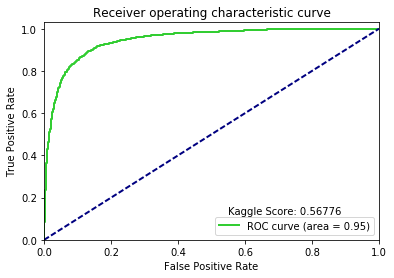

In [8]:
    X_train,Y_train,X_test,Y_test = split_data(X_binary,train)
    score = get_retrained_score(X_train,Y_train, X_test,c[1])
    plot(Y_test,score,kaggle[1])

#Step 3: Get AUC-ROC plot for X_tfidf

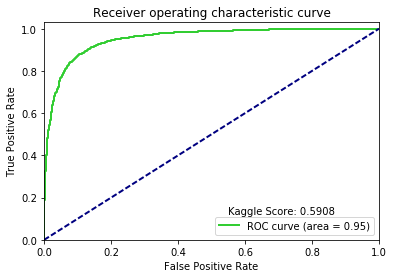

In [9]:
    X_train,Y_train,X_test,Y_test = split_data(X_tfidf,train)
    score = get_retrained_score(X_train,Y_train, X_test,c[2])
    plot(Y_test,score,kaggle[2])

#Step 4: Get AUC-ROC plot for X_binary_imbalance

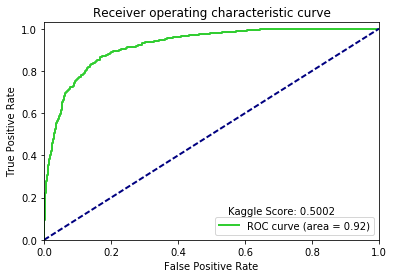

In [10]:
    X_train,Y_train,X_test,Y_test = split_data_imbalance(X_binary_imbalance,train,train_index)
    score = get_retrained_score(X_train,Y_train, X_test,c[3])
    plot(Y_test,score,kaggle[3])

## Comments on Question 3

I add the kaggle test score for each matrix to the respective AUC-ROC graph. From the results above, we could see that X_tiidf matrix gives the best kaggle test score (0.5908). The X_binary_imbalance perform the worst, with kaggle test score (0.5002) and AUC score (0.92), it might be caused by the deletion of records (loss of information). X_counts and X_binary matrix perform very similarly, X_binary matrix has a higher kaggle test score, which might perform better on avoiding overfitting.

## Question 4: Drawing learning curve for X_counts

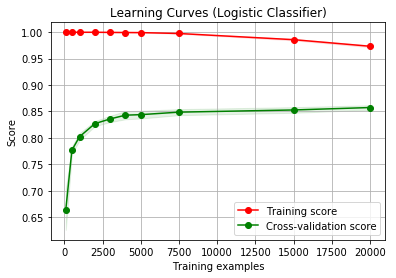

In [24]:
    estimator = LogisticRegression()
    title = "Learning Curves (Logistic Classifier)"
    X_counts = sparse.csr_matrix(X_counts)
    X = X_counts
    y = train["sentiment"]
    plot_learning_curve(estimator, title, X, y)

## Interprete the learning curve

From the learning curve above, we could see that, when we increase the training examples, the cross-validation becomes higher. For small training examples, although we get good training score, the cross-validation performance is poor, it might be caused by overfitting in small dataset. 